In [9]:
import osmnx as ox
import geopandas as gpd
import os

# 画图
import geopandas as gpd
import matplotlib.pyplot as plt

import json
from shapely.geometry import shape

print("已开始")

# 1. 获取 City of London 区域边界
place_name = "City of London, London, England, United Kingdom"
gdf = ox.geocode_to_gdf(place_name)

# 2. 自定义过滤器：抓取所有适合骑行、包含 cycleway 的道路（参考官方源代码逻辑）
custom_filter = (
    '["highway"]["area"!~"yes"]'
    '["highway"!~"abandoned|bus_guideway|construction|corridor|elevator|escalator|footway|'
    'motor|no|planned|platform|proposed|raceway|razed|steps"]'
    '["bicycle"!~"no"]["service"!~"private"]'
)

# 3. 下载图形网络数据
graph = ox.graph_from_polygon(gdf.geometry[0], custom_filter=custom_filter)

# 4. 转为 GeoDataFrame（仅保留边）
edges = ox.graph_to_gdfs(graph, nodes=False)

# 5. 结果为所有开放使用、包含或适合骑行的道路
bike_lanes = edges

# 6. 确保输出文件夹存在
output_dir = "../data"
os.makedirs(output_dir, exist_ok=True)

# 7. 导出为 GeoJSON 文件
output_path = os.path.join(output_dir, "city_of_london_bike_accessible_roads.geojson")
bike_lanes.to_file(output_path, driver="GeoJSON")

print(f"导出成功：{output_path}")

# 读取原始 geojson 文件
with open("../data/city_of_london_bike_accessible_roads.geojson", "r", encoding="utf-8") as f:
    data = json.load(f)

# 提取所有属性和几何信息
records = []
for feature in data["features"]:
    props = feature["properties"]
    geom = shape(feature["geometry"])
    props["geometry"] = geom
    records.append(props)

# 转为 GeoDataFrame
roads = gpd.GeoDataFrame(records, crs="EPSG:4326")
print(roads.columns.tolist())

已开始
导出成功：../data\city_of_london_bike_accessible_roads.geojson
['u', 'v', 'key', 'osmid', 'highway', 'lanes', 'maxspeed', 'name', 'ref', 'oneway', 'reversed', 'length', 'access', 'tunnel', 'width', 'junction', 'service', 'bridge', 'est_width', 'geometry']


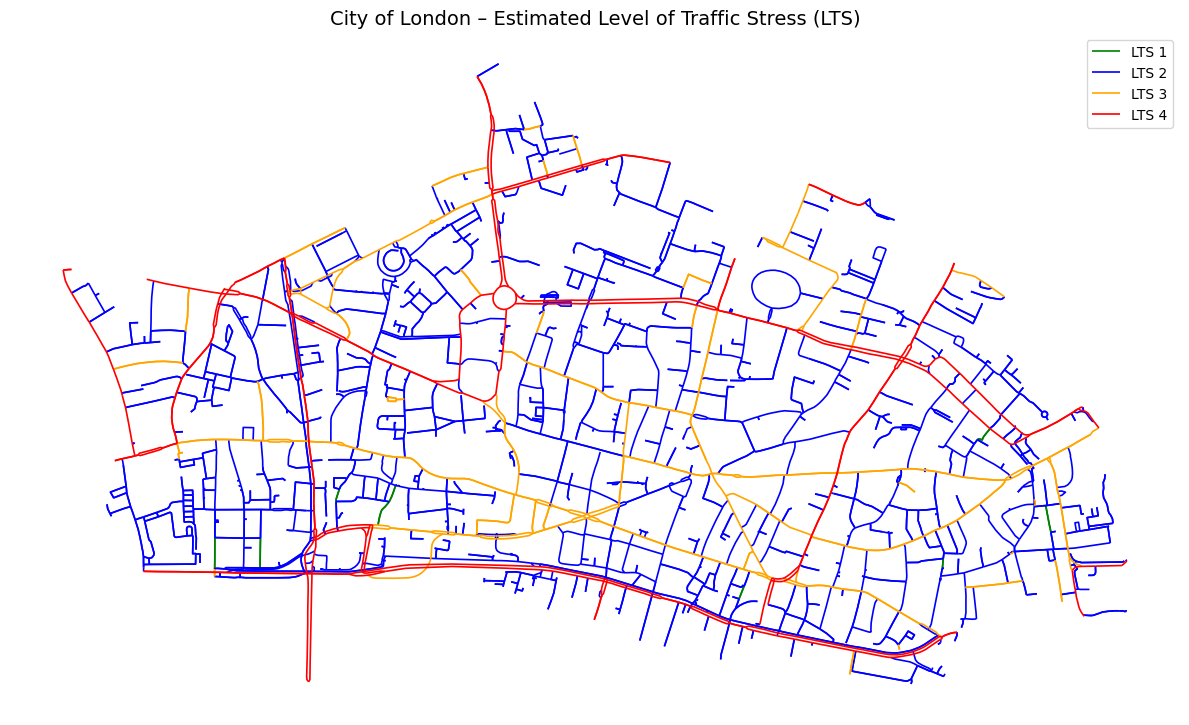

In [10]:
# === 2. 清洗 maxspeed 和 lanes 字段 ===
def parse_speed(s):
    if s is None:
        return None
    if isinstance(s, list):
        s = s[0]
    try:
        return int(str(s).split()[0])
    except:
        return None

def parse_lanes(l):
    if isinstance(l, list):
        try:
            return int(l[0])
        except:
            return None
    try:
        return int(l)
    except:
        return None

roads["maxspeed"] = roads["maxspeed"].apply(parse_speed)
roads["lanes"] = roads["lanes"].apply(parse_lanes)

# === 3. 判断是否为自行车道 ===
def has_cycleway_tag(hwy):
    if isinstance(hwy, list):
        return "cycleway" in hwy
    return hwy == "cycleway"

roads["has_bike_lane"] = roads["highway"].apply(has_cycleway_tag)


# === 4. 默认参数（缺失时填充）
DEFAULT_SPEED = {
    "residential": 25, "tertiary": 30, "secondary": 35, "primary": 40, "trunk": 45
}
DEFAULT_LANES = {
    "residential": 2, "tertiary": 2, "secondary": 3, "primary": 4, "trunk": 4
}


# === 5. LTS 估算函数（Conveyal逻辑简化版）
def estimate_lts_conveyal(functional_class, has_bike_lane, speed_limit, lane_count):
    # 🔧 修复 list 类型 highway
    if isinstance(functional_class, list):
        functional_class = functional_class[0]

    speed_limit = speed_limit or DEFAULT_SPEED.get(functional_class, 35)
    lane_count = lane_count or DEFAULT_LANES.get(functional_class, 3)
    has_bike_lane = has_bike_lane if has_bike_lane is not None else False

    if functional_class in ["residential", "living_street"]:
        if has_bike_lane and speed_limit <= 25:
            return 1
        elif speed_limit <= 25:
            return 2
        else:
            return 3
    if has_bike_lane and speed_limit <= 30 and lane_count <= 2:
        return 2
    if has_bike_lane and speed_limit <= 35:
        return 3
    if not has_bike_lane and functional_class in ["residential", "tertiary"] and speed_limit <= 30:
        return 3
    if functional_class in ["primary", "secondary", "trunk"] and not has_bike_lane:
        return 4
    if lane_count >= 4 or speed_limit >= 45:
        return 4
    return 2


# === 6. 应用函数估算 LTS
roads["lts"] = roads.apply(lambda row: estimate_lts_conveyal(
    row.get("highway"),
    row.get("has_bike_lane"),
    row.get("maxspeed"),
    row.get("lanes")
), axis=1)

# === 7. 可视化 LTS 分类地图 ===
color_map = {1: "green", 2: "blue", 3: "orange", 4: "red"}
roads["color"] = roads["lts"].map(color_map)

fig, ax = plt.subplots(figsize=(12, 12))
for level in sorted(roads["lts"].dropna().unique()):
    roads[roads["lts"] == level].plot(ax=ax, color=color_map[level], linewidth=1.2, label=f"LTS {level}")

ax.set_title("City of London – Estimated Level of Traffic Stress (LTS)", fontsize=14)
ax.axis("off")
ax.legend()
plt.tight_layout()
plt.show()